In [45]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import dcor

import sys
sys.path.append("/home/yangz2/projects/1906-pcgml/pcgml-gmmVae-exp/modules/")

from metrics import Metrics
m = Metrics(game='smba')

Each of the following JSONs contain the about 10000 chunks generated from one GM-VAE. The component of this GM-VAE is specificed by the last digit of the file name.

In [46]:
path_to_gens = "../smba_generations_2_to_7"
os.listdir(path_to_gens)

['.ipynb_checkpoints',
 'smba_gmvae_8.json',
 'smba_gmvae_7.json',
 'smba_gmvae_6.json',
 'smba_gmvae_2.json',
 'smba_gmvae_3.json',
 'smba_gmvae_1.json',
 'smbWithPath-allLevels-chunks-int.json',
 'smba_gmvae_4.json',
 'smba_gmvae_5.json']

Define some utility functions.

In [47]:
def load_json_as_array(json_fpath):
    with open(json_fpath, "r") as json_f:
        return np.array(json.load(json_f))

In [48]:
def get_metrics_from_chunks(chunks):
    return m.compute_metrics_for_arrays(
        arrays=chunks, 
        metrics_to_compute=['linearity', 'leniency', 'num_jumps', 'density', 'interestingness']
    )

Compute metrics of the generations of each GM-VAE.

In [49]:
metrics_per_json = []
for json_fname in tqdm_notebook([i for i in os.listdir(path_to_gens) if i.split('.')[-1] == 'json']):
    json_fpath = os.path.join(path_to_gens, json_fname)
    chunks = load_json_as_array(json_fpath)
    metrics_per_json.append(get_metrics_from_chunks(chunks))

Save metrics for all GM-VAE in one JSON, since the computation of these metrics take time.

In [50]:
metrics_per_json_np = [np.array(i) for i in metrics_per_json]

In [51]:
with open('metrics_per_json.json', 'w+') as json_f:
    json.dump([i.tolist() for i in metrics_per_json_np], json_f)

Load the metrics and normalize them. Normalization is needed since different metrics are on different scales.

In [57]:
with open('metrics_per_json.json', 'r') as json_f:
    metrics_per_json_np = [np.array(i) for i in json.load(json_f)]

In [58]:
# make sure all metrics are on the same scale
for i in metrics_per_json_np:
    i -= i.mean(axis=1).reshape(-1, 1)
    i /= i.std(axis=1).reshape(-1, 1)

## Compute 95% boostrap confidence interval for each distance

This section is very, very slow; it can be skipped until later.

In [41]:
def bootstrap_ci(org_mets, gen_mets, confidence_level=0.95, num_bootstraps=10):
    
    # org_mets and gen_mets are of shape (num_chunks, num_metrics)
    
    num_org = len(org_mets)
    num_gen = len(gen_mets)
    
    e_distances = []
    
    for i in tqdm_notebook(np.arange(num_bootstraps)):
    
        random_idxs_org = np.random.randint(num_org, size=num_org)
        random_idxs_gen = np.random.randint(num_gen, size=num_gen)
    
        org_mets_samp = org_mets[random_idxs_org]
        gen_mets_samp = gen_mets[random_idxs_gen]
        
        e_distances.append(dcor.energy_distance(org_mets_samp, gen_mets_samp))
        
    ordered = sorted(e_distances)
    lower = np.percentile(ordered, (1-confidence_level)/2 * 100)
    upper = np.percentile(ordered, (confidence_level+((1-confidence_level)/2)) * 100)

    return lower, upper

In [42]:
org_idx = 6
org_mets = metrics_per_json_np[org_idx]
lowers = []
uppers = []
for mets in tqdm_notebook(metrics_per_json_np):
    lower, upper = bootstrap_ci(org_mets.T, mets.T)
    lowers.append(lower)
    uppers.append(upper)

KeyboardInterrupt: 

In [ ]:
with open("lowers.json", "w+") as json_f:
    json.dump(lowers, json_f)

In [ ]:
with open("uppers.json", "w+") as json_f:
    json.dump(uppers, json_f)

In [ ]:
with open("lowers.json", "r") as json_f:
    lowers = json.load(json_f)

In [ ]:
with open("uppers.json", "r") as json_f:
    uppers = json.load(json_f)

## Compute distances

For each GMVAE, compute the energy distance between the normalized metrics of its generations with the original data.

In [ ]:
org_idx = 6
org_mets = metrics_per_json_np[org_idx]
e_distances = []
for i, mets in enumerate(metrics_per_json_np):
    e_distances.append(dcor.energy_distance(org_mets.T, mets.T))

In [ ]:
with open("e_distances.json", "w+") as json_f:
    json.dump(e_distances, json_f)

In [ ]:
with open("e_distances.json", "r") as json_f:
    e_distances = json.load(json_f)

In [ ]:
num_components_array = [8, 7, 6, 2, 3, 1, 0, 4, 5]

## Plot distances against number of components

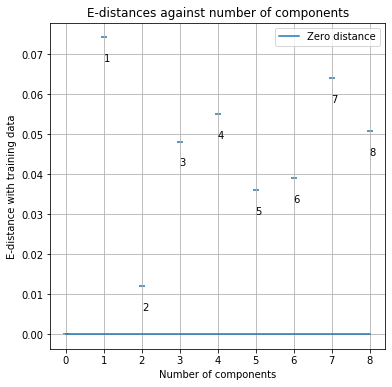

In [59]:
plt.figure(figsize=(6, 6))

plt.title('E-distances against number of components')

plt.scatter(num_components_array, e_distances, marker="_")
plt.plot([0, 8], [0, 0], label='Zero distance')

for x, y in zip(num_components_array, e_distances):
    if x == 0:
        plt.annotate("Original data with itself", xy=(x, y-0.004))
    else:
        plt.annotate(f"{x}", xy=(x, y-0.006))

# # confidence bounds
# plt.scatter(num_components_array, lowers, marker='_')
# plt.scatter(num_components_array, uppers, marker='_')

plt.xlabel('Number of components'); plt.ylabel('E-distance with training data')
plt.legend(loc="upper right")
plt.grid()

plt.show()

TODO:
- Construct bootsrap confidence intervals for the plot above (done)
- Train more epochs so GM-VAEs have more time to discover the structure (current models are only trained for 100 epochs) - problem: the model starts to overfit a lot
- Train models from 1-10 components because maybe less components is more semantically meaningful and thus help with generation
- Using spherical guassians for VAE rather full-ranked gaussians
- Essential part is region enclosing the training latent vectors / unlearned region
- Problem with overfitting